# Определение стоимости автомобилей

## Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Необходимо построить модель, которая умеет её определять. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

## Описание данных

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**

- `Price` — цена (евро)

## Оглавление
1. Подготовка данных
2. Обучение моделей
3. Анализ моделей

In [1]:
# Блок импорта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Математические операции
import math
from math import sqrt

# Простые модели, на которых будем проверять
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

# Возможный бонус
from sklearn.linear_model import Ridge

# Вспомогательные методы
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import  make_scorer

# буст
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

pd.options.mode.chained_assignment = None

# Подготовка данных

In [2]:
try:
    df = pd.read_csv('autos.csv')
except FileNotFoundError: 
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## Промежуточный вывод
Изходя из поставленной цели (определить стоимость автомобиля) можно сделать вывод, что не все имеющиеся признаки необходимы для дальнейшей работы. Такие признаки как: дата создания обьявления или последняя активность пользователя.

Другим примером будет признак количества выложенных фотографий автомобиля. Он может повлиять на привлекательность обьявления и скорость продажи, но не на финальную стоимость сделки.

Удалим их :)

In [4]:
del df['DateCrawled'], df['DateCreated'], df['NumberOfPictures'], df['PostalCode'], df['LastSeen']
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


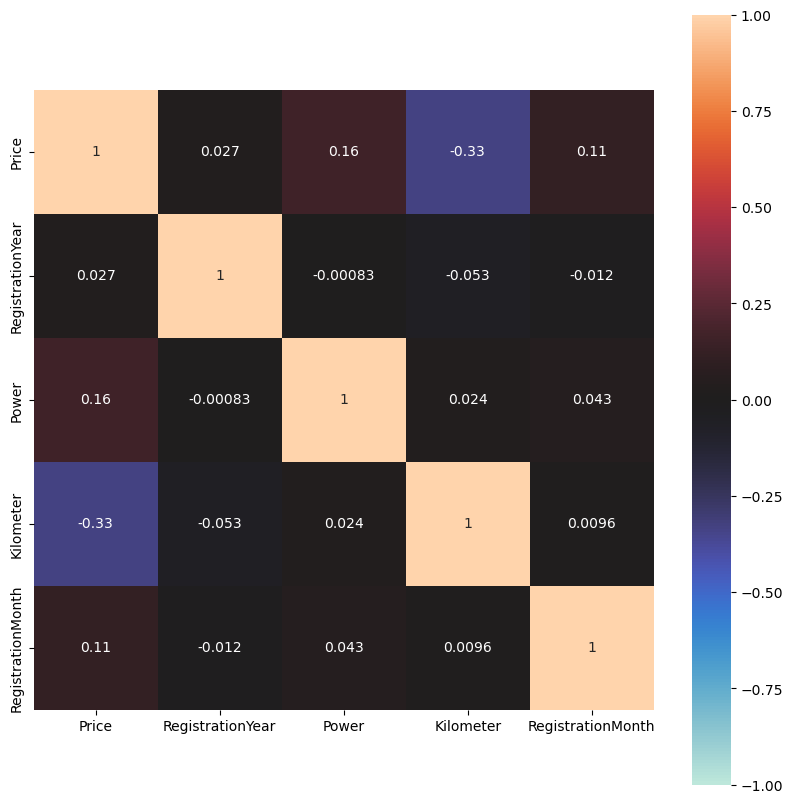

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax);

## Промежуточный вывод
- Типы данных заданы корректно.
- Обнаружено множество пропусков.
- Имеются выбросы в обе стороны. Год выпуска находится в неадекватном диапозоне, лошадиные силы скачут от 0 до 20000. Настораживает нулевой год выпуска машины.
- Значимой корреляции признаков не обнаружено.

## Мощность ТС

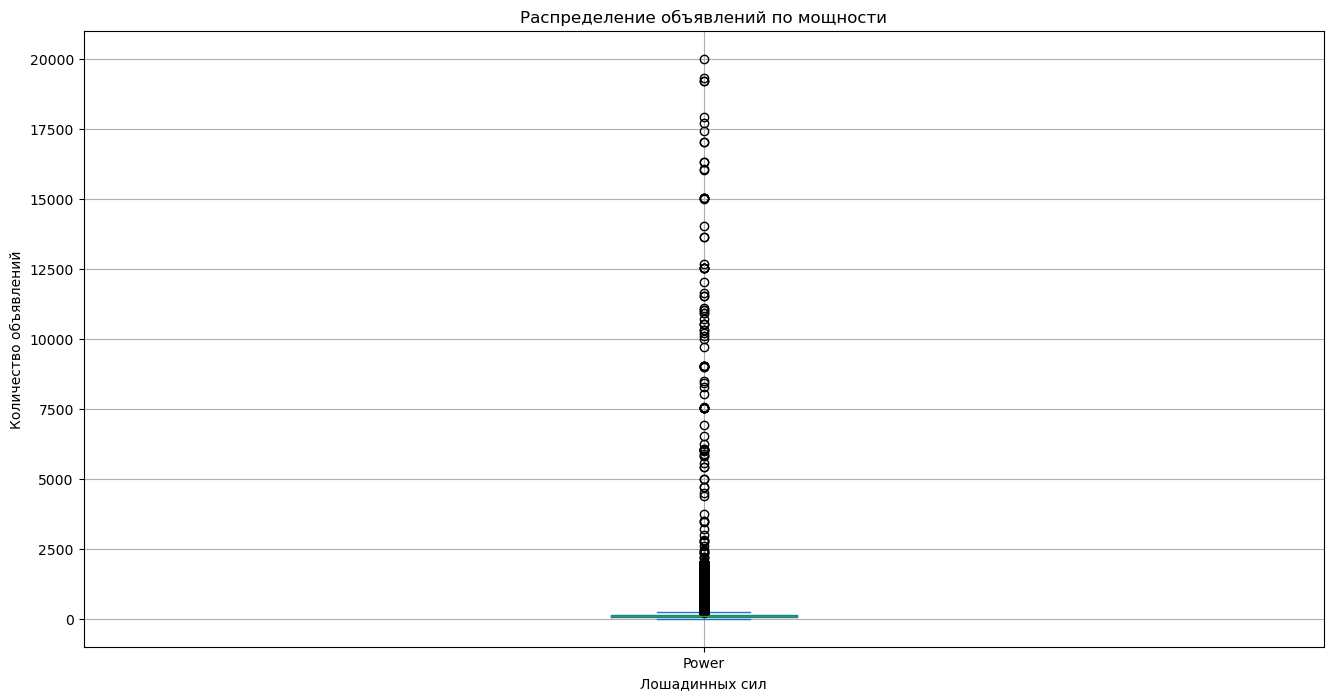

In [8]:
fig, ax = plt.subplots()
ax.set_title('Распределение объявлений по мощности')
ax.set_xlabel('Лошадинных сил')
ax.set_ylabel('Количество объявлений')
df['Power'].plot(kind='box', figsize=(16,8), grid = True);

Конечно на планете земля есть очень мощные и очень дорогие гиперкары, однако их количество ничтожно мало в общей массе транспортных средств, поэтому мы смело может убрать выбросы по мощности, улучшив тем самым качество наших данных.

In [9]:
df = df[(df['Power'] <= df['Power'].quantile(0.998)) & (df['Power'] >= df['Power'].quantile(0.01))]

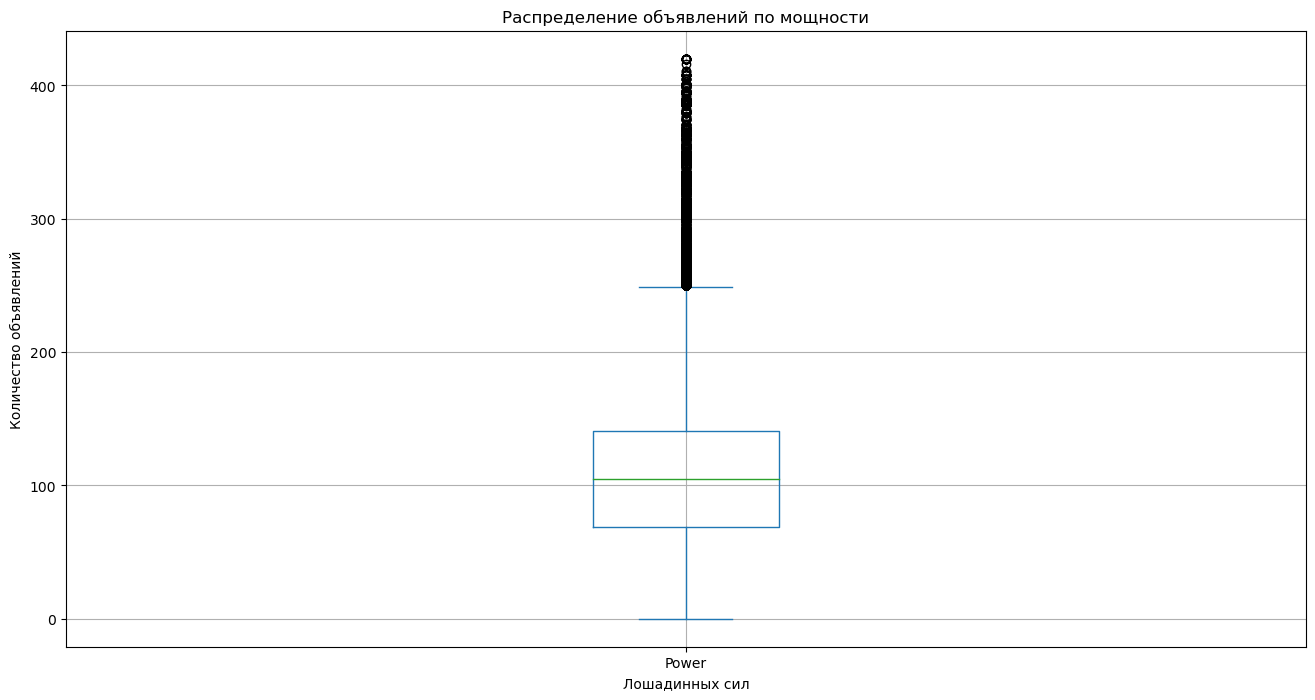

In [10]:
fig, ax = plt.subplots()
ax.set_title('Распределение объявлений по мощности')
ax.set_xlabel('Лошадинных сил')
ax.set_ylabel('Количество объявлений')
df['Power'].plot(kind='box', figsize=(16,8), grid = True);

In [11]:
df['Power'].sort_index(ascending=True).value_counts()

0      40225
75     24023
60     15897
150    14590
101    13298
       ...  
337        1
353        1
282        1
297        1
377        1
Name: Power, Length: 390, dtype: int64

Огромное количество нулевых значений мощности автомобиля явно не пойдет на пользу нашим моделям.

Скорее всего нули символизируют пропущенное значение мощности при составлении обьявления. Не стоит унывать, скорее всего нам удастся исправить эту ситуацию, заполнив нулевые значения по уже имеющимся, исходя из модели машины и года её выпуска.

In [12]:
# Создадим функцию подсчета мощности автомобиля по трем признакам
def calculate_power(df, brand, model, year):
    df_part = df[(df['RegistrationYear'] == year) & (df['Brand'] == brand) & (df['Model'] == model)]
    if (df_part['Power'].count() == 0):
        # если не нашли по году, бренду и модели, пробуем только по бренду + модели
        df_part = df[(df['Brand'] == brand) & (df['Model'] == model)]
    
    median_power = df_part['Power'].median()
    
    if (math.isnan(median_power)):
        median_power = 0
        
    return median_power

In [13]:
# Отделим из общей массы машины с минимальный количеством лощадиных сил, посмотрим на них
low_power_df = df[df['Power'] < 30][['Brand', 'Model', 'RegistrationYear']]
low_power_df.count()

Brand               41133
Model               34562
RegistrationYear    41133
dtype: int64

In [14]:
# Заполним незаполненные модели категорией unknown
low_power_df['Model'] = low_power_df['Model'].fillna('unknown')

In [15]:
# Избавимся от явных дубликатов
low_power_df = low_power_df.drop_duplicates()
low_power_df.count()

Brand               5181
Model               5181
RegistrationYear    5181
dtype: int64

In [16]:
%%time

for row in low_power_df.itertuples(index=True):
    year = getattr(row, "RegistrationYear") # getattr вычленяет из строчки год выпуска автомобиля из соответствующей строки
    brand = getattr(row, "Brand")
    model = getattr(row, "Model")
    median = calculate_power(df, brand, model, year)
    searchRow = ((df['Power'] < 30)) & (df['Brand'] == brand) & (df['Model'] == model) & (df['RegistrationYear'] == year)
    df.loc[searchRow, 'Power'] = median

CPU times: total: 6min 19s
Wall time: 6min 23s


In [17]:
# Посмотрим, сколько нулевых значений осталось
df[df['Power'] == 0]['Price'].count()

7761

In [18]:
# Остались только какие-то уникальные модели, которые не встретились в остальной выборке, удалим их
df = df[df['Power'] != 0]

### Вывод по мощности ТС
Мы проанализировали график распределения мощностей ТС в нашем датасете, отбросили анамальные значения для массового рынка автомобилей.

Поработали с нулевыми значениями лощадиных сил, заменив максимальное количество значений для которых смогли найти аналогичные автомобили.

## Даты выпуска ТС

In [19]:
df['RegistrationMonth'].value_counts()

3     33980
0     32823
6     31117
4     28918
5     28795
7     26835
10    25837
12    23967
11    23950
9     23583
1     22723
8     22367
2     21023
Name: RegistrationMonth, dtype: int64

Количество нулевых значений месяца выпуска не позволит нам просто избавиться от такой группы. Это нанесет сильный урон нашему датасету, остается принять, что ноль сведетельствует об отсутствии данных о месяце выпуска транспортного средства.

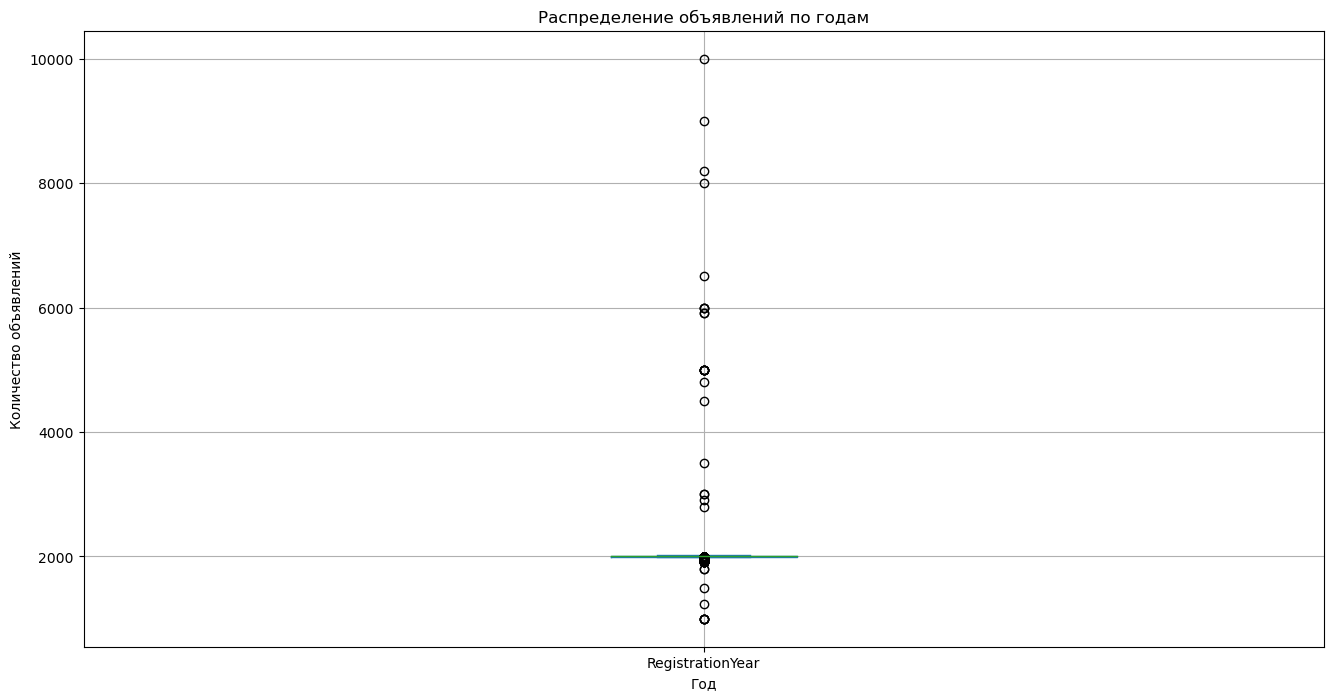

In [20]:
fig, ax = plt.subplots()
ax.set_title('Распределение объявлений по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Количество объявлений')
df['RegistrationYear'].plot(kind='box', figsize=(16,8), grid = True);

In [21]:
# Удалим выбросы по году
df = df[(df['RegistrationYear'] >= 1970) & (df['RegistrationYear'] <= 2017)]

In [22]:
# df['DateCreated'].max() -> 2016

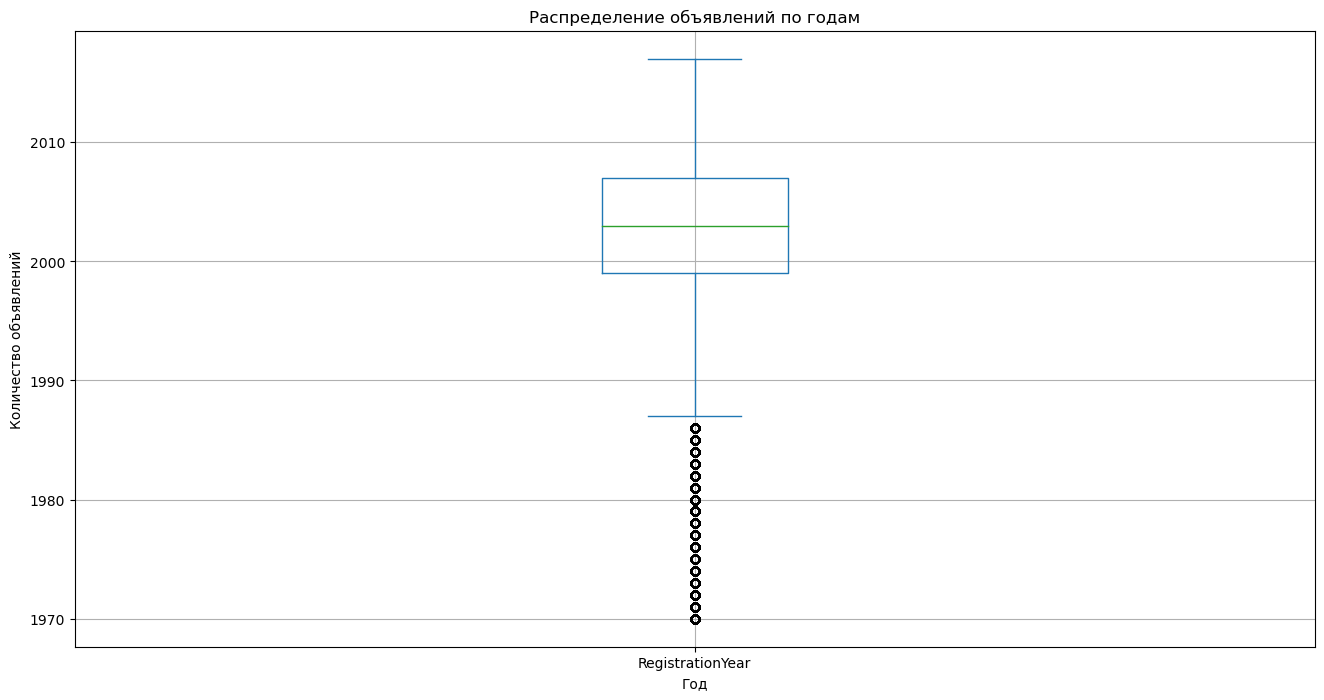

In [23]:
fig, ax = plt.subplots()
ax.set_title('Распределение объявлений по годам')
ax.set_xlabel('Год')
ax.set_ylabel('Количество объявлений')
df['RegistrationYear'].plot(kind='box', figsize=(16,8), grid = True);

### Вывод по датам выпуска ТС
Было принято решение не удалять нулевые значения месяца выпуска ТС, так как данных с таким значением крайне много. Будем считать, что это отдельная группа ТС для которых не указан месяц выпуска.

Убрали выбросы по году ТС, отобрав лишь актуальные данные в период с 1970 по 2017 год.

## Цена ТС

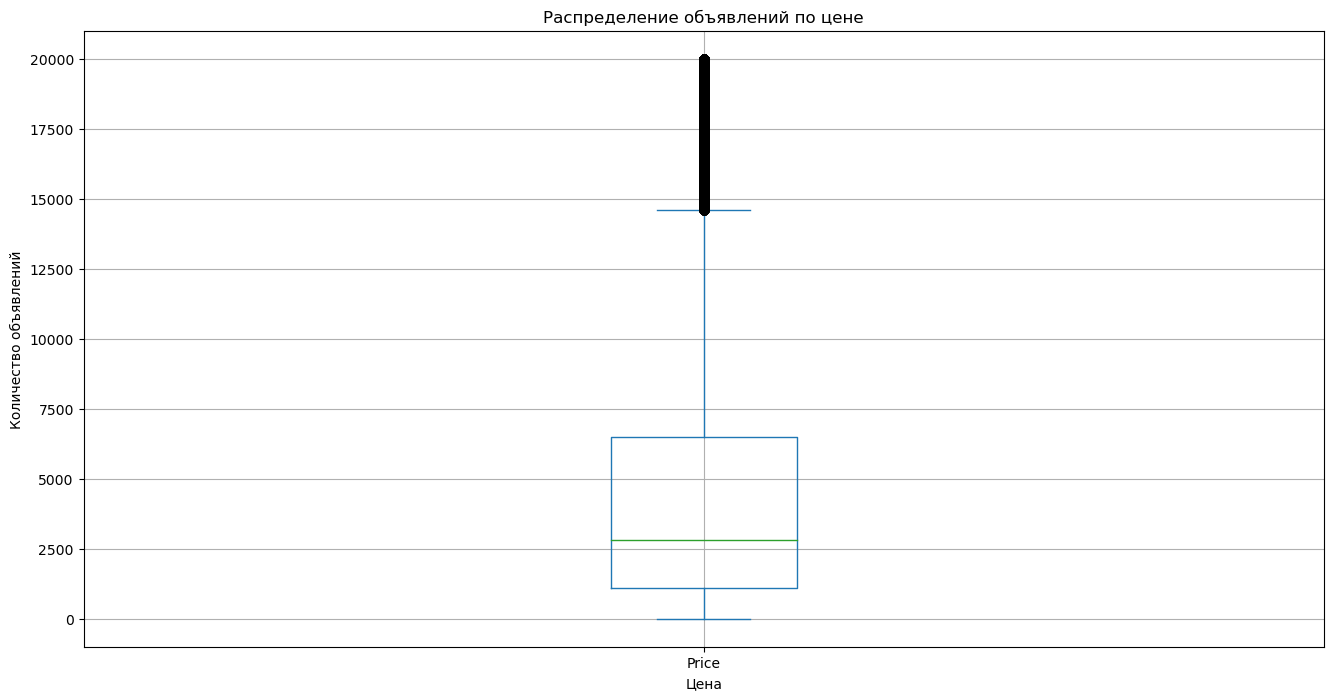

In [24]:
fig, ax = plt.subplots()
ax.set_title('Распределение объявлений по цене')
ax.set_xlabel('Цена')
ax.set_ylabel('Количество объявлений')
df['Price'].plot(kind='box', figsize=(16,8), grid = True);

In [25]:
# Посмотрим, что у нас с ценой (есть нулевые значения)
df[df['Price'] < 10]['Price'].value_counts()

0    9079
1     962
5      22
2       7
9       6
3       5
7       2
8       1
Name: Price, dtype: int64

Нулевая стомоисть - ужасная проблема для всего нашего исследования. Нужно предпринять аналогичные действия для устранения проблемы.

In [26]:
def calculate_price(df, brand, model, year):
    # в среднем не будем рассчитывать нулевые значения иначе поолученные значения будут сильно занижены
    df_part = df[(df['Price'] >= 10) & (df['RegistrationYear'] == year) & (df['Brand'] == brand) & (df['Model'] == model)]
    if (df_part['Price'].count() == 0):
        # если не нашли по году, бренду и модели, пробуем только по бренду + модели
        df_part = df[(df['Price'] >= 10) & (df['Brand'] == brand) & (df['Model'] == model)]
    
    mean_price = df_part['Price'].mean()
    
    if (math.isnan(mean_price)):
        mean_price = 0
        
    return mean_price

In [27]:
# Заполним незаполненные модели категорией unknown
low_price_df = df[df['Price'] < 10][['Brand', 'Model', 'RegistrationYear']]
low_price_df['Model'] = low_price_df['Model'].fillna('unknown')

In [28]:
# Избавимся от явных дубликатов
low_price_df = low_price_df.drop_duplicates()
low_price_df.count()

Brand               2394
Model               2394
RegistrationYear    2394
dtype: int64

In [29]:
%%time

for row in low_price_df.itertuples(index=True):
    year = getattr(row, "RegistrationYear")
    brand = getattr(row, "Brand")
    model = getattr(row, "Model")
    mean_price = calculate_price(df, brand, model, year)
    searchRow = (df['Price'] < 100) & (df['Brand'] == brand) & (df['Model'] == model) & (df['RegistrationYear'] == year)
    df.loc[searchRow, 'Price'] = mean_price

CPU times: total: 2min 47s
Wall time: 2min 47s


In [30]:
df[df['Price'] < 10]['Price'].count()

949

In [31]:
# Пожертвуем тысячей обьявлений в угоду качеству данных :)
df = df[df['Price'] >= 10]

### Вывод по ценам ТС
Нам удалось исправить побавляющее большинство нулевых значений цены на автомобили. Неисправные значения были удалены.

## Ремонт ТС

In [32]:
df['Repaired'].value_counts()

no     241989
yes     34821
Name: Repaired, dtype: int64

In [33]:
df['Repaired'].isna().sum()

63594

Более 64 тысяч пропусков сведетельствуют нам о существовании третьей категории значений в данном признаке, когда нам доподлено не известно был ли ремонт у данного транспортного средства.

Наиболее разумным представляется вариант перекодировки значений данного признака в числовые с заполнением пропусков новым значением.

Таким образом сделаем три группы:
- 0 - ремонта не было
- 1 - данные о ремонте неизвестны
- 2 - ремонт состоялся

In [34]:
df['Repaired'] = df['Repaired'].fillna(1)

In [35]:
def fill_not_repaired(value):
    if value == 'no':
        return 0
    elif value == 'yes':
        return 2
    else:
        return value

In [36]:
df['Repaired'] = df['Repaired'].apply(fill_not_repaired)
df['Repaired'].value_counts()

0    241989
1     63594
2     34821
Name: Repaired, dtype: int64

### Вывод по ремонту ТС

## Тип ТС

In [37]:
df['VehicleType'].value_counts()

sedan          89934
small          78657
wagon          64396
bus            28425
convertible    19866
coupe          15720
suv            11683
other           2980
Name: VehicleType, dtype: int64

In [38]:
# Выделим пропуски в отдельную группу undifiend
df['VehicleType'] = df['VehicleType'].fillna('undefined')

In [39]:
df['FuelType'].value_counts()

petrol      210441
gasoline     97075
lpg           5172
cng            550
hybrid         228
other          127
electric        80
Name: FuelType, dtype: int64

petrol + gasoline - бензиновые двигатели - 0\
lpg + cng - газ - 1\
hybrid - гибрид - 2 \
electric - электрический - 3
undefined - 4

In [40]:
df['FuelType'] = df['FuelType'].fillna(4)

In [41]:
def fill_fuel_type(value):
    if value == 'petrol' or value == 'gasoline':
        return 0
    elif value == 'lpg' or value == 'cng':
        return 1
    elif value == 'hybrid':
        return 2
    elif value == 'electric':
        return 3
    elif value == 'other':
        return 4
    else:
        return value

In [42]:
df['FuelType'] = df['FuelType'].apply(fill_fuel_type)
df['FuelType'].value_counts()

0    307516
4     26858
1      5722
2       228
3        80
Name: FuelType, dtype: int64

In [43]:
# Аналогичным образом поступим и для остальных признаков
# т.к. их восстановление или проблематично или не имеет решающей роли
df['Gearbox'] = df['Gearbox'].fillna('undefined')
df['Model'] = df['Model'].fillna('undefined')
df['Brand'] = df['Brand'].fillna('undefined')

In [44]:
# Посмотрим, что получилось
df = df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340404 entries, 0 to 340403
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              340404 non-null  int64  
 1   Price              340404 non-null  float64
 2   VehicleType        340404 non-null  object 
 3   RegistrationYear   340404 non-null  int64  
 4   Gearbox            340404 non-null  object 
 5   Power              340404 non-null  float64
 6   Model              340404 non-null  object 
 7   Kilometer          340404 non-null  int64  
 8   RegistrationMonth  340404 non-null  int64  
 9   FuelType           340404 non-null  int64  
 10  Brand              340404 non-null  object 
 11  Repaired           340404 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 31.2+ MB


In [45]:
# Удалим уже не нужные датасеты
del low_price_df, low_power_df

## Вывод по подготовке данных
Мы проделали масштабную работу:
- Удалили ненужные для предсказания признаки
- Разобрались с выбросами и пропусками в следующих признаках:
    - Мощность двигателя ТС
    - Дата (месяц и год) выпуска ТС
    - Цена ТС
- Выделили группу необозначенных(`undefined`) данных в слудеющих признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`.

# Обучение моделей

In [46]:
# Определим random_state
RANDOM_STATE=12345

In [47]:
# Выделим категориальные признаки (RegistrationMonth и FuelType хоть они и имеют тип int64 однако по прежнему являются категориальными признаками)
category_features = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'RegistrationMonth']

# Выделим числовые признаки
number_features = ['RegistrationYear', 'Power', 'Kilometer', 'Repaired']

In [48]:
# Оставим в датасете только то, что нам нужно для обучения моделей
df = df[number_features + category_features + ['Price']];

In [49]:
# Создадим копью полученного датасета для работы с простыми моделями методом copy()
df_simple = df.copy()
df_simple.head()

,RegistrationYear,Power,Kilometer,Repaired,VehicleType,Gearbox,Brand,Model,FuelType,RegistrationMonth,Price
0,1993,75.0,150000,1,undefined,manual,volkswagen,golf,0,0,480.0
1,2011,190.0,125000,2,coupe,manual,audi,undefined,0,5,18300.0
2,2004,163.0,125000,1,suv,auto,jeep,grand,0,8,9800.0
3,2001,75.0,150000,0,small,manual,volkswagen,golf,0,6,1500.0
4,2008,69.0,90000,0,small,manual,skoda,fabia,0,7,3600.0


In [50]:
features = df_simple.drop(columns='Price')
target = df_simple['Price']

In [50]:
#Сначала отделим от датасета 60% наблюдений - это будет обучающая выборка. 
#Оставщиеся данные поделим пополам - на тестовую и валидационную выборки.
#Таким образом мы разобьем данные в соотношении 60/20/20.
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=RANDOM_STATE)

In [52]:
encoder = OrdinalEncoder()

encoder.fit(features_train[category_features])
features_train[category_features] = encoder.transform(features_train[category_features])
features_valid[category_features] = encoder.transform(features_valid[category_features])
features_test[category_features] = encoder.transform(features_test[category_features])

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b>👋:</b> Сделал с Ordinal Encoder и также изменил разбиение на три части.
</div> 

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера №2<a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 

In [53]:
# Проведем скалирование числовых признаков
scaler = StandardScaler()

scaler.fit(features_train[number_features])
features_train[number_features] = scaler.transform(features_train[number_features])
features_valid[number_features] = scaler.transform(features_valid[number_features])
features_test[number_features] = scaler.transform(features_test[number_features])

features_train.head()

,RegistrationYear,Power,Kilometer,Repaired,VehicleType,Gearbox,Brand,Model,FuelType,RegistrationMonth
259214,1.325189,0.426323,-1.048771,2.417161,4.0,1.0,1.0,177.0,0.0,6.0
48213,-0.470971,-0.248727,0.572870,0.914889,4.0,0.0,2.0,11.0,0.0,2.0
302097,-1.219370,-0.538034,0.572870,-0.587384,4.0,1.0,38.0,116.0,0.0,10.0
100513,-1.668410,1.159235,0.572870,-0.587384,6.0,1.0,14.0,240.0,0.0,8.0
146462,1.025829,-0.653757,-1.859591,-0.587384,5.0,1.0,3.0,45.0,0.0,2.0


In [54]:
# Определим функцию для подсчета RMSE
def rmse(target, predicted):
    return sqrt(mse(target, predicted))

In [55]:
# Чтобы не собирать вручную результаты, напишем класс, который будет сохранять время обучения, время предсказания и RMSE
class Model_class:
    # Конструктор принимающий на вход название модели и её тип
    def __init__(self, name, model):
        self.name = name
        self.model = model
        
    # Метод класса по обучению модели
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
        
    # Метод класса по предсказанию значений
    def predict(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
        
    # Метод класса по выводу значений затраченного времени на разных этапах + RMSE
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [56]:
# Создадим переменную, где будут храниться результаты
results = []

In [57]:
def print_result(result):
    print('|{: >20}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >20}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(info[0], info[1], info[2], info[3]))

## Простые модели

### Cлучайный лес

In [58]:
%%time

# Попробуем обучить случайный лес
parameters = {'n_estimators': range(5,11,5),'max_depth': range(1,8,3), 'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}

model = RandomForestRegressor()
grid = GridSearchCV(model, parameters, cv=3, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)
# 
grid.best_params_

CPU times: total: 50.9 s
Wall time: 50.9 s


{'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 10}

Полученные параметры методом grid
{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [59]:
grid.best_score_

-4401289.516169827

In [60]:
# Задаем полученные гиперпараметры для содели случайного леса
model_forest = RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=2, n_estimators=10, random_state=RANDOM_STATE)

# Создаем объект класса Model_class
model_forest_helper = Model_class('Random forest', model_forest)

# Обучаем модель
model_forest_helper.fit(features_train, target_train)

# Делаем предсказание
model_forest_helper.predict(features_valid, target_valid)

#Заносим данные о времени работы и RMSE в переменную
results.append(model_forest_helper.getResult())

In [61]:
print_result(results)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           2.40360|           0.04884|  2103.08352|


Попадание с первой попытки, мы уже выполнили поставленное условие RMSE < 2500

### Линейная регрессия

In [62]:
# Попробуем линейную регрессию
model_lr = LinearRegression()
model_lr_helper = Model_class('Linear regression', model_lr)
model_lr_helper.fit(features_train, target_train)
model_lr_helper.predict(features_valid, target_valid)
results.append(model_lr_helper.getResult())

In [63]:
print_result(results)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           2.40360|           0.04884|  2103.08352|
|   Linear regression|           0.74797|           0.02994|  2942.40826|


### Вывод по простым моделям

Лишь одна модель из числа "простых" пробила желаемую отметку целевой метрики и это случайный лес. К сожалению линейной регресси не удалось получить желаемый результат.

Стоит отметить, что Линейная регрессия обучается в 3 раза быстрее случайного дерева, однако ключевая метрика у неё хуже.

## Библиотеки градиентного бустинга

Ниже приведена сравнительная таблица трех основных библиотек градиентного бустинга. В рамках данного проекта я буду использовать две: `CatBoost` и `LightGBM`.

После прочтения пары статей, опираясь на изложенные в них материалы и данную сравнительную таблицу я пришел к выводу, что две библиотеки по разному подходят к работе с категориальными переменными. `CatBoost` использует OHE, а `LightGBM` использует специальный алгоритм, чтобы найти значение разделения категориальных признаков.

Для максимально объективного сравнения двух библиотек создадим для них равные условия.
- Заново отскалируем числовые признаки обработанного датасета
- Для LightGBM подготовим категориальные признаки с помощью OrdinalEncoding
- Для CatBoost категориальные признаки готовить не будем

![file](https://miro.medium.com/max/1400/1*z97K_Bu0oAZKDTDJiYKnyQ.png)

In [64]:
# Подготовим заново признаки для бустинга
features = df.drop(columns='Price')
target = df['Price']

# Разделим нашу выборку в пропорции 75/25 (без валидационной)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=RANDOM_STATE)

# Проведем скалирование
scaler = StandardScaler()
scaler.fit(features_train[number_features])
features_train[number_features] = scaler.transform(features_train[number_features])
features_valid[number_features] = scaler.transform(features_valid[number_features])
features_test[number_features] = scaler.transform(features_test[number_features])

features_train.head()

,RegistrationYear,Power,Kilometer,Repaired,VehicleType,Gearbox,Brand,Model,FuelType,RegistrationMonth
259214,1.325189,0.426323,-1.048771,2.417161,sedan,manual,audi,q3,0,6
48213,-0.470971,-0.248727,0.572870,0.914889,sedan,auto,bmw,3er,0,2
302097,-1.219370,-0.538034,0.572870,-0.587384,sedan,manual,volkswagen,golf,0,10
100513,-1.668410,1.159235,0.572870,-0.587384,suv,manual,jeep,wrangler,0,8
146462,1.025829,-0.653757,-1.859591,-0.587384,small,manual,chevrolet,aveo,0,2


In [65]:
# Для LGBM дополнительно обработаем категориальные признаки
features_train_lgbm = features_train.copy()
features_valid_lgbm = features_valid.copy()
features_test_lgbm = features_test.copy()

# Месяц регистрации и тип двигателя преобразовывать не нужно они были обработаны вручную
category_features_lgbm = ['VehicleType', 'Gearbox', 'Brand', 'Model']

encoder = OrdinalEncoder()
encoder.fit(features_train_lgbm[category_features_lgbm])
features_train_lgbm[category_features_lgbm] = encoder.transform(features_train_lgbm[category_features_lgbm])
features_valid_lgbm[category_features_lgbm] = encoder.transform(features_valid_lgbm[category_features_lgbm])
features_test_lgbm[category_features_lgbm] = encoder.transform(features_test_lgbm[category_features_lgbm])

features_train_lgbm.head()

,RegistrationYear,Power,Kilometer,Repaired,VehicleType,Gearbox,Brand,Model,FuelType,RegistrationMonth
259214,1.325189,0.426323,-1.048771,2.417161,4.0,1.0,1.0,177.0,0,6
48213,-0.470971,-0.248727,0.572870,0.914889,4.0,0.0,2.0,11.0,0,2
302097,-1.219370,-0.538034,0.572870,-0.587384,4.0,1.0,38.0,116.0,0,10
100513,-1.668410,1.159235,0.572870,-0.587384,6.0,1.0,14.0,240.0,0,8
146462,1.025829,-0.653757,-1.859591,-0.587384,5.0,1.0,3.0,45.0,0,2


### LightGBM

In [66]:
%%time

lgbm = LGBMRegressor(boosting_type='gbdt', verbose=0, seed=RANDOM_STATE, force_row_wise = True)
lgbm_params = {'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(20, 61, 20), 'num_leaves': range(20, 41, 10)}

grid_lgbm = GridSearchCV(lgbm, lgbm_params, cv=3, scoring='neg_mean_squared_error')
grid_lgbm.fit(features_train_lgbm, target_train);

grid_lgbm.best_params_

CPU times: total: 2min 15s
Wall time: 36.9 s


{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}

'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40

In [68]:
# Посмотрим, что получилось в итоге
model_lgbm = grid_lgbm.best_estimator_
model_lgbm_helper = Model_class('LightGBM', model_lgbm)
model_lgbm_helper.fit(features_train_lgbm, target_train)
model_lgbm_helper.predict(features_valid_lgbm, target_valid)
results.append(model_lgbm_helper.getResult())

In [69]:
print_result(results)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           2.40360|           0.04884|  2103.08352|
|   Linear regression|           0.74797|           0.02994|  2942.40826|
|            LightGBM|           0.46077|           0.09076|  1677.27855|


### CatBoost

In [70]:
%%time

cbr = CatBoostRegressor(loss_function='RMSE',silent=True, cat_features=category_features, random_seed=RANDOM_STATE)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring='neg_mean_squared_error')
grid_cbr.fit(features_train, target_train);

grid_cbr.best_params_

CPU times: total: 7min
Wall time: 3min 34s


{'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

In [71]:
# Посмотрим, что получилось в итоге
model_cbr = grid_cbr.best_estimator_
model_cbr_helper = Model_class('CatBoost', model_cbr)
model_cbr_helper.fit(features_train, target_train)
model_cbr_helper.predict(features_valid, target_valid)
results.append(model_cbr_helper.getResult())

In [72]:
print_result(results)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|       Random forest|           2.40360|           0.04884|  2103.08352|
|   Linear regression|           0.74797|           0.02994|  2942.40826|
|            LightGBM|           0.46077|           0.09076|  1677.27855|
|            CatBoost|           4.02015|           0.18553|  1679.64463|


## Вывод по обучению моделей
Безоговочным лидером является модель `LightGBM` она показала наилучший результат целевой метрики, а также быстрее всех обучилась, затратив на предсказание сравнимое с остальными время. Проведем тест именно для неё!

# Анализ моделей

In [74]:
#очистим список результатов
results = []

model_lgbm_helper.predict(features_test_lgbm, target_test)

results.append(model_lgbm_helper.getResult())

In [75]:
print_result(results)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|            LightGBM|           0.46077|           0.18750|  1693.27717|


# Общий вывод

Время подводить итоги проделанной работы:\
В рамках подготовки данных мы:
- Избавились от ненужных признаков
- Разобрались с выбросами
- Разобрались с пропусками
- Довели до идеала некоторые категориальные признаки, требующие доработки

В рамках Обучения моделей мы:
- Разбили наш дата сет на три выборки
- Отдельно обучили и протестировали простые модели (случайное дерево и линейная регрессия)
- Сравнили имеющиеся на данных момент библиотеки градиентого бустинга
- Обучили и оценили две модели градиентого бустинга
- Выбрали самую успешную модель `LightGBM`

Финалом данного проекта стала проверка лучшей модели `LightGBM` на тестовой выборке. Наша модель показала превосходные результаты:

Время обучения - 0.46077\
Время предсказания - 0.18750\
RMSE - 1693.27717
       
Данная модель отвечает всем требованиям* заказчика!

*Требования заказчика:
- качество предсказания RMSE < 2500;
- минимальное время обучения модели;
- минимальное время предсказания модели.
